# Comparison of longest common subsequence (LCS) algorithms

**COT 6405 Analysis of Algorithms, Spring 2020**

**Christian Garbin**

## Introduction

This notebook compares **longest common subsequence** (defined below) algorithms:

- Brute-force: generates combinations of subseqences and check if they are common subsequences.
- Dynamic programming: takes advantage of common subproblems to not evaluate the same subsequence more than once.
- Hirschbger's linear space: a dynamic programming approach that uses significantly less space.

The comparison measures:

- Runtime efficiency: how long it take to find a longest common subsequence.
- Space efficiency: how much space is used to find a longest common subsequence.

The code used in the experiments is written in Pyhton 3.x.

## Longest common subsequence

Given a sequence $X = <x_1, x_2, …, x_m>$, another sequence $Z$ is a **subsequence** of $X$ if there is a strictly increasing sequence $<i_1, i_2, …, i_k>$ of indices of $X$ such that for all $j = 1, 2, …, k$, we have $x_{ij} = z_j$ \[CLRS01\].

For example:

- Given the sequence $X = < A, B, C, B, D, A, B >$
- The sequence $Z = < B, C, D, B >$ is a subsequence of $X$, with indices $< 2, 3, 5, 7 >$

Given two sequences, a **common subsequence** is a sequence that is common to both sequences. A **longest common subsequence** (LCS) is a maximum-length common subsequence.

For example:

- Given the sequences $X = < A, B, C, B, D, A, B >$ and $Y = < B, D, C, A, B, A >$
- The sequence $< B, C, A >$ is a common subsequence
- The sequence $< B, C, B, A, >$ is a longest common subsequence
- The sequence $< B, D, A, B >$ is another LCS, therefore LCSs do not have to be unique

### Applications

Applications of LCS include determining if two organisms are similar by comparing their DNAs. In this case, "similar" can be determined by the longest common subsequence between the DNAs. The longer the subsequence, the more common the organisms are.

Building on the DNA example, LCS can be used as a form of compression. Using a pre-built suffix tree, an LCS-based solution compressed the human genome from about 3 GB to just over 8 MB \[BAF16\].

LCS is also used in version control systems to produce the "diff", the minimal amount of additions and deletions that transform the older version of a file into the new version, also known as the "edit distance" \[NAV01\]. For example, this output of Git's diff between two versions of a file shows deletion and addition of two lines to transform the old verision of the file into the new one:

    @@ -33,15 +33,11 @@ class ModifiedFile(BaseCommit):
         '''Number of lines added to the file in this commit.'''
         deleted = Column(Integer)
    -    '''Number of lines deleted from the file in tihs commit.'''
    +    '''Number of lines deleted from the file in this commit.'''
    -    commit_id = Column(String)
    +    commit_id = Column(String, ForeignKey('commit_info.commit_id'))

## Notebook structure

The remainder of this notebook is structured as follows:

- **Algorithms**: describes the algorithms used in the tests.
- **Initialization and verification****: initializes the notebook (import Python modules and set important variables) and verifies that the algorithms are working before using them.
- **Measurement and analysis**: run the tests to collect the metrics and analyzes those metrics.
- **Code**: documents the code structure, functionality, and other technical aspects found during the development and execution of the tests.

## Algorithms

Three algorithms will be analyzed:

- **Brute-force** The simplest LCS algorithm is the brute-force approach: generate subsequences of the smaller sequence and check if they are also a subsequence of the larger sequence. This is an exponential algorithm, $O(2^n$), given that there are $2^n$ subsequences to try in the worst case scenario. Space usage depends the implementation. A naive implementation would generate all combinations of the smaller sequence ahead time, using $O(2^n)$ space. An optimized implementation generates one permutation of the smaller sequence at a time, using $O(min(m,n))$ space.
-  **Dynamic programming** It makes use of the optimal substructure of the LCS, solving smaller subproblems only once, combining the solutions. This algorithm has an $$O(nm)$ running time. Its space is also $O(nm)$.
- **Hirschberg’s linear space** algorithm \[HIR75\] It is a similar approach to the dynamic programming one but, as the name indicates, making more efficient use of space. The running time is still $O(nm)$, but space is reduced to $O(m+n)$ \[KT05\].

## Initialization and verification

Set a seed to make pseudo-random generator generate the same sequence across runs. This makes it easier to compare different runs of the algorithms.

In [3]:
import random
random.seed(42)

Check that the algorithms work by testing them against controlled input.

There are three part to the tests:

1. Automated tests that check against well-defined inputs. They are meant to be easy to debug, in case an algorithm fails.
1. Tests with longer inputs that simular DNA strands. They test more realistic scenarios, but still short enough to run fast.
1. A visual check, by printing the aligned subsequence. They guard against the test code itself having a failure that generates false positives.

In [2]:
import lcs_test

lcs_test.test(visualize=True)

All basic tests passed
All DNA tests passed
Visual inspection:
                         lcs_brute_force:  TACCGCATTATCGATACTTTTACCGACAAC
                         lcs_brute_force:  ....G.......G.T.CTTT.A...ACAA. size=12
    lcs_dynamic_programming_matrix_numpy:  ....G.......G.T.CTTT.A...ACAA. size=12
                    lcs_hirschberg_numpy:  ....G.......G.T.CTTT.A...ACAA. size=12


## Measurements and analysis

To illustrate a real-life scenario, the code checks if a DNA strand is part of
a larger DNA sequence \[[WIK20](https://en.wikipedia.org/wiki/Subsequence#Applicationshttps://en.wikipedia.org/wiki/Subsequence#Applications)\].

In [4]:
# Force reload because this piece of code frequently changes
import importlib
import metrics
importlib.reload(metrics);

### Runtime tests and analysis

#### Data collection

In [5]:
rt_results_raw, rt_results_summary = metrics.runtime(verbose=1, file='runtime')

Loading from file


In [6]:
display(rt_results_raw)

,Algorithm,Sequence size,Subsequence size,Test number,Runtime (s)
0,Brute force,1000,100,1,0.000071
1,Brute force,1000,100,2,0.000061
2,Brute force,1000,100,3,0.000060
3,Brute force,1000,100,4,0.000059
4,Brute force,1000,100,5,0.000062
...,...,...,...,...,...
85,Hirschberg NumPy,100000,10000,6,298.062996
86,Hirschberg NumPy,100000,10000,7,296.694249
87,Hirschberg NumPy,100000,10000,8,296.023982
88,Hirschberg NumPy,100000,10000,9,302.362678


In [7]:
display(rt_results_summary.sort_values(by=[metrics.DF_SEQ_SIZE,
    metrics.DF_SUBSEQ_SIZE]))

,Algorithm,Sequence size,Subsequence size,Runtime (s)
0,Brute force,1000,100,0.000063
3,Dynamic programming NumPy,1000,100,0.017004
6,Hirschberg NumPy,1000,100,0.035454
1,Brute force,10000,1000,0.000684
4,Dynamic programming NumPy,10000,1000,1.534184
7,Hirschberg NumPy,10000,1000,3.183443
2,Brute force,100000,10000,0.006109
5,Dynamic programming NumPy,100000,10000,155.446082
8,Hirschberg NumPy,100000,10000,297.822916


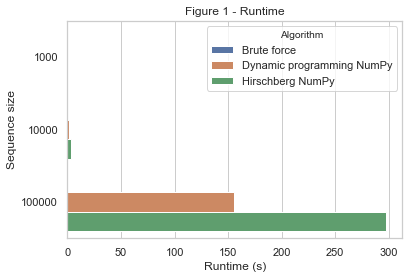

In [14]:
import seaborn as sns
sns.set(style='whitegrid')
sns.barplot(data=rt_results_summary, y=metrics.DF_SEQ_SIZE,
            x=metrics.DF_RUNTIME, hue=metrics.DF_ALGORITHM,
            orient='h').set_title('Figure 1 - Runtime');

### Space usage and analysis

In [9]:
mem_results_raw, mem_results_summary = metrics.memory(verbose=1, file='memory')

Loading from file


In [10]:
display(mem_results_raw)

,Algorithm,Sequence size,Subsequence size,Test number,Memory (KiB),Runtime (s)
0,Brute force,1000,100,1,0.003906,0.023162
1,Brute force,1000,100,2,0.003906,0.019378
2,Brute force,1000,100,3,0.000000,0.020617
3,Brute force,1000,100,4,0.000000,0.021210
4,Brute force,1000,100,5,0.000000,0.018491
...,...,...,...,...,...,...
85,Hirschberg NumPy,100000,10000,6,0.000000,298.792635
86,Hirschberg NumPy,100000,10000,7,0.000000,307.600254
87,Hirschberg NumPy,100000,10000,8,0.289062,305.471942
88,Hirschberg NumPy,100000,10000,9,0.015625,305.605863


In [11]:
display(mem_results_summary)

,Algorithm,Sequence size,Subsequence size,Memory (KiB),Runtime (s)
0,Brute force,1000,100,0.003906,0.025980
1,Brute force,10000,1000,0.023438,0.024597
2,Brute force,100000,10000,0.308594,0.020007
3,Dynamic programming NumPy,1000,100,0.000000,0.042362
4,Dynamic programming NumPy,10000,1000,38.187500,1.616665
5,Dynamic programming NumPy,100000,10000,3815.218750,155.376315
6,Hirschberg NumPy,1000,100,0.000000,0.040131
7,Hirschberg NumPy,10000,1000,0.097656,3.114633
8,Hirschberg NumPy,100000,10000,0.816406,307.600254


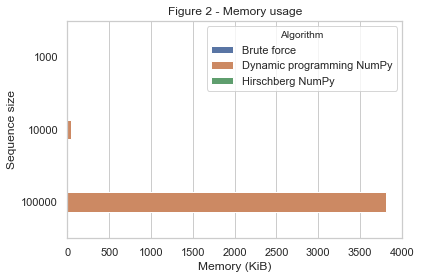

In [16]:
sns.barplot(data=mem_results_summary, y=metrics.DF_SEQ_SIZE,
            x=metrics.DF_MEMORY, hue=metrics.DF_ALGORITHM,
            orient='h').set_title('Figure 2 - Memory usage');

## Code structure

> Describe structure of the code

## References

\[BAF16\] Beal, R., Afrin, T., Farheen, A. et al. _A new algorithm for “the LCS problem” with application in compressing genome resequencing data_. BMC Genomics 17, 544 (2016). https://doi.org/10.1186/s12864-016-2793-0, accessed 2020-03-16.

\[CLRS01\] Thomas H. Cormen, Charles E. Leiserson, Ronald L. Rivest, and Clifford Stein. 2001. *Introduction to Algorithms*, 2<sup>nd</sup> edition. MIT Press.

\[HIR75\] Hirschberg, Daniel S. _A linear space algorithm for computing maximal common subsequences._ Commun. ACM 18 (1975): 341-343.

\[KT05\] Jon Kleinberg and Eva Tardos. 2005. _Algorithm Design_. Addison-Wesley Longman Publishing Co., Inc., USA.

\[NAV01\] Navarro, Gonzalo. 2001. _A guided tour to approximate string matching_. ACM Computing Surveys. http://users.csc.calpoly.edu/~dekhtyar/570-Fall2011/papers/navarro-approximate.pdf, accessed 2020-03-27.

\[WIK20\] Wikipedia, _Subsequence_ entry, _Applications_ section, https://en.wikipedia.org/wiki/Subsequence#Applications, accessed 2020-03-18.

References used in the code are annotated directly in the code.